In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Data analysis

In [46]:
male_dataset = pd.read_csv('data/pop_vardai_vyrai.txt',delimiter=' ',encoding="UTF-16")
female_dataset = pd.read_csv('data/pop_vardai_moterys.txt',delimiter=' ',encoding="UTF-16")

In [47]:
print(male_dataset)

            name  popularity
0           Abas           0
1        Abdijus           0
2        Abdonas           0
3         Abdula           0
4         Abelis           2
...          ...         ...
3845  Žigimantas          25
3846  Žigymantas           0
3847    Žigintas           0
3848    Žilvynas           0
3849    Žimantas           0

[3850 rows x 2 columns]


In [48]:
print(female_dataset.shape)
print(male_dataset.shape)

(4235, 2)
(3850, 2)


We have around 8085 names total. How many of those are 0? How many are >100?

In [49]:
print(f"Number of male names with 0 popularity: {(male_dataset['popularity']==0).sum()}")
print(f"Number of male names with >=100 popularity: {(male_dataset['popularity']>=100).sum()}")
print(f"Max popularity for male name: {(male_dataset['popularity']).max()}")
print(f"Average popularity for male name: {(male_dataset['popularity']).mean().round(2)}\n")
print(f"Number of female names with 0 popularity: {(female_dataset['popularity']==0).sum()}")
print(f"Number of female names with >=100 popularity: {(female_dataset['popularity']>=100).sum()}")
print(f"Max popularity for female name: {(female_dataset['popularity']).max()}")
print(f"Average popularity for female name: {(female_dataset['popularity']).mean().round(2)}")



Number of male names with 0 popularity: 1391
Number of male names with >=100 popularity: 404
Max popularity for male name: 17236
Average popularity for male name: 141.73

Number of female names with 0 popularity: 1583
Number of female names with >=100 popularity: 499
Max popularity for female name: 11642
Average popularity for female name: 164.3


There are a lot of names with 0 popularity in both datasets. These names are either improper, foreign or otherwise unused in the modern naming scheme.

For the sake of a more accurate model, we will be omiting names with 0 popularity.

Additionally, we will try to see what kind of model we can get if we take the n most popular names as the training data.

For the sake of curiosity, let's see how the distribution of name popularities looks like in intervals.

[0,10], [11,100], [101,1000], [1001,2000], [2001,5000], [5000,10000], [10000,20000]

In [50]:
bins = [0,10,100,1000,2000,5000,10000,20000]
labels = ["[0;10]","[11;100]","[101;1000]","[1001;2000]","[2001;5000]","[5001;10000]","[10001;20000]"]
merged_names = pd.concat([male_dataset,female_dataset],ignore_index=True)
merged_names['popularity_bin'] = pd.cut(merged_names['popularity'],bins=bins,labels=labels)
interval_counts = merged_names['popularity_bin'].value_counts().sort_index()
print(interval_counts)

popularity_bin
[0;10]           3089
[11;100]         1126
[101;1000]        602
[1001;2000]       120
[2001;5000]       118
[5001;10000]       47
[10001;20000]       9
Name: count, dtype: int64


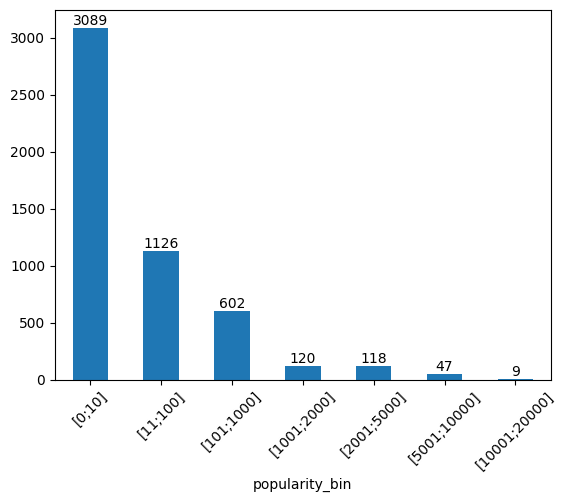

In [51]:
ax = interval_counts.plot(kind='bar')
plt.xticks(rotation=45)
for i, value in enumerate(interval_counts):
    ax.text(i, value + 0.2, str(value), ha='center', va='bottom', fontsize=10)

Top 500 popular names (seperate for male and female)

In [52]:
male_sorted = male_dataset.sort_values(by='popularity',ascending=False)
female_sorted = female_dataset.sort_values(by='popularity',ascending=False)

top_500_male=male_sorted.head(500)
top_500_female = female_sorted.head(500)

In [53]:
top_500_male

,name,popularity
2278,Lukas,17236
2330,Mantas,12171
3368,Tomas,10842
2366,Matas,10601
904,Dovydas,8654
...,...,...
1114,Emetas,58
3275,Taironas,56
2620,Nikodemas,56
2270,Lorenas,56


In [54]:
top_500_female

,name,popularity
1497,Gabrielė,11642
1804,Gabriele,11642
3939,Viktorija,10711
1494,Gabija,10425
1870,Ieva,10212
...,...,...
3761,Terese,103
3749,Terėsė,103
3463,Severina,102
106,Akvilina,100


# Namesformer model

We will be making 4 different models:
1. All-model. It will take all the name data.
2. Partial-model. It will take all names, which have >0 popularity.
3. Popular_1000-model. It will take the top 1000 most popular names as its training data.
4. Popular_500-model. It will take the top 500 most popular names as its training data.

The models will be trained seperately on female data and male data, thus there will be a total of 8 models.

We will modify NameDataset to accomodate directly giving it a dataframe.

In [80]:
class NameDataset(Dataset):
    def __init__(self, dataset):
        self.names = dataset
        self.chars = sorted(list(set(''.join(self.names) + ' ')))  # Including a padding character
        self.char_to_int = {c: i for i, c in enumerate(self.chars)}
        self.int_to_char = {i: c for c, i in self.char_to_int.items()}
        self.vocab_size = len(self.chars)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx] + ' '  # Adding padding character at the end
        encoded_name = [self.char_to_int[char] for char in name]
        return torch.tensor(encoded_name)

In [81]:
male_dataset = pd.read_csv('data/pop_vardai_vyrai.txt',delimiter=' ',encoding="UTF-16")
female_dataset = pd.read_csv('data/pop_vardai_moterys.txt',delimiter=' ',encoding="UTF-16")
male_sorted = male_dataset.sort_values(by='popularity',ascending=False)
female_sorted = female_dataset.sort_values(by='popularity',ascending=False)

male_dataset_nozero = male_dataset[male_dataset['popularity']>0]
female_dataset_nozero = female_dataset[female_dataset['popularity']>0]

male_top1000 = male_sorted.head(1000)
female_top1000 = female_sorted.head(1000)

male_top500 = male_sorted.head(500)
female_top500 = male_sorted.head(500)


In [149]:
chosen_dataset = female_top1000['name'].str.lower().values
dataset = NameDataset(chosen_dataset)
print(chosen_dataset)

['gabrielė' 'gabriele' 'viktorija' 'gabija' 'ieva' 'emilija' 'grėta'
 'greta' 'kamile' 'kamilė' 'karolina' 'ugnė' 'ugne' 'austėja' 'austeja'
 'agnė' 'agne' 'monika' 'evėlina' 'evelina' 'laura' 'deimantė' 'deimante'
 'migle' 'miglė' 'gintarė' 'gintare' 'egle' 'eglė' 'simona' 'aiste'
 'aistė' 'justina' 'urte' 'urtė' 'goda' 'viltė' 'vilte' 'rugilė' 'rugile'
 'kristina' 'augustė' 'auguste' 'dovilė' 'ema' 'paulina' 'rūta' 'ruta'
 'erika' 'kotryna' 'karina' 'liepa' 'akvile' 'akvilė' 'sandra' 'indre'
 'indrė' 'lėja' 'leja' 'saulė' 'saule' 'marija' 'samanta' 'patricija'
 'diana' 'milda' 'gustė' 'guste' 'sofija' 'smilte' 'smiltė' 'amėlija'
 'amelija' 'eva' 'jūlija' 'julija' 'kornėlija' 'kornelija' 'gerda' 'gėrda'
 'brigita' 'lina' 'rusnė' 'rusne' 'justė' 'juste' 'nikita' 'luknė' 'lukne'
 'aurėlija' 'aurelija' 'roberta' 'milana' 'giedrė' 'giedre' 'raminta'
 'dominyka' 'nėringa' 'neringa' 'aukse' 'auksė' 'anastasija' 'meda'
 'skaiste' 'skaistė' 'elija' 'luka' 'daniele' 'danielė' 'rasa' 'vakare'
 

In [150]:
dataset.int_to_char

{0: ' ',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'y',
 23: 'z',
 24: 'č',
 25: 'ė',
 26: 'ę',
 27: 'š',
 28: 'ū',
 29: 'ž'}

In [151]:
[dataset.int_to_char[num] for num in dataset[0].numpy()]

['g', 'a', 'b', 'r', 'i', 'e', 'l', 'ė', ' ']

In [152]:
def pad_collate(batch):
    padded_seqs = pad_sequence(batch, batch_first=True, padding_value=0)
    input_seq = padded_seqs[:, :-1]
    target_seq = padded_seqs[:, 1:]
    return input_seq, target_seq

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

In [153]:
class MinimalTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, forward_expansion):
        super(MinimalTransformer, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, 100, embed_size))
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.output_layer = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        positions = torch.arange(0, x.size(1)).unsqueeze(0)
        x = self.embed(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = self.output_layer(x)
        return x

In [154]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [155]:
def train_model(model, dataloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        model.train()  # Ensure the model is in training mode
        total_loss = 0.0
        batch_count = 0

        for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
            optimizer.zero_grad()
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)
            output = model(input_seq)
            loss = criterion(output.transpose(1, 2), target_seq)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1

        average_loss = total_loss / batch_count
        print(f'Epoch {epoch+1}, Average Loss: {average_loss}')

In [ ]:

model = MinimalTransformer(vocab_size=dataset.vocab_size, embed_size=128, num_heads=8, forward_expansion=4)
model = model.to(device)
train_model(model, dataloader,epochs=500)

c:\Users\Audrius\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Average Loss: 1.6053078658878803
Epoch 2, Average Loss: 1.258300505578518
Epoch 3, Average Loss: 1.2079856246709824
Epoch 4, Average Loss: 1.207101408392191
Epoch 5, Average Loss: 1.172185942530632
Epoch 6, Average Loss: 1.1543466839939356
Epoch 7, Average Loss: 1.151187788695097
Epoch 8, Average Loss: 1.153362661600113
Epoch 9, Average Loss: 1.1533187851309776
Epoch 10, Average Loss: 1.1469779014587402
Epoch 11, Average Loss: 1.140562016516924
Epoch 12, Average Loss: 1.1219287943094969
Epoch 13, Average Loss: 1.1278440579771996
Epoch 14, Average Loss: 1.14394767023623
Epoch 15, Average Loss: 1.119593309238553
Epoch 16, Average Loss: 1.112451858818531
Epoch 17, Average Loss: 1.1104636825621128
Epoch 18, Average Loss: 1.114569867029786
Epoch 19, Average Loss: 1.1059079598635435
Epoch 20, Average Loss: 1.094810288399458
Epoch 21, Average Loss: 1.1119532883167267
Epoch 22, Average Loss: 1.1006654184311628
Epoch 23, Average Loss: 1.1128670908510685
Epoch 24, Average Loss: 1.084928

# Sampling

In [157]:
model.to("cpu")

MinimalTransformer(
  (embed): Embedding(30, 128)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Drop

In [158]:
def sample(model, dataset, start_str='a', max_length=20, temperature=1.0):
    assert temperature > 0, "Temperature must be greater than 0"
    model.eval()  # Switch model to evaluation mode
    with torch.no_grad():
        # Convert start string to tensor
        chars = [dataset.char_to_int[c] for c in start_str]
        input_seq = torch.tensor(chars).unsqueeze(0)  # Add batch dimension
        
        output_name = start_str
        for _ in range(max_length - len(start_str)):
            output = model(input_seq)
            
            # Apply temperature scaling
            logits = output[0, -1] / temperature
            probabilities = torch.softmax(logits, dim=0)
            
            # Sample a character from the probability distribution
            next_char_idx = torch.multinomial(probabilities, 1).item()
            next_char = dataset.int_to_char[next_char_idx]
            
            if next_char == ' ':  # Assume ' ' is your end-of-sequence character
                break
            
            output_name += next_char
            # Update the input sequence for the next iteration
            input_seq = torch.cat([input_seq, torch.tensor([[next_char_idx]])], dim=1)
        
        return output_name

In [159]:
print('More confident:')
for _ in range(10):
    print(' ', sample(model, dataset, start_str='r', temperature=0.5))  # More confident

print('\nMore diverse/creative:')
for _ in range(10):
    print(' ', sample(model, dataset, start_str='r', temperature=1.5))  # More diverse

More confident:
  roruta
  rorolė
  rile
  ranta
  ranėja
  rina
  rarinta
  rora
  rora
  rojolė

More diverse/creative:
  rėmaueta
  rėvatėja
  rophiterizilenianeli
  robrotė
  rekydraja
  ronetė
  rokidotė
  ryta
  romisėjijandadongija
  rėtareta


In [160]:
torch.save(model, 'models/model_female_top1000.pt')